# Travaux Pratiques : Auto-Encodeurs (AE) et Auto-Encodeurs Variationnels (VAE)


## Objectifs Pédagogiques

1.  **Illustrer l'encodage** : Comprendre comment un réseau neuronal apprend une **représentation compressée** (l'**espace latent** ou code $\mathbf{z}$) de données complexes (images).
2.  **Comprendre la Génération** : Maîtriser le concept du **VAE** qui, grâce à la régularisation de l'espace latent (Divergence KL), peut non seulement reconstruire mais aussi **générer** de nouvelles données plausibles et permettre l'**interpolation sémantique**.

Nous utiliserons la base de données **Fashion-MNIST** (images 28x28 en niveaux de gris) avec le framework **PyTorch**.

---

## I. Préambule : Configuration et Chargement des Données

**Note Pédagogique sur Fashion-MNIST** : Ce jeu de données est choisi pour sa complexité supérieure à MNIST (chiffres). Les articles de mode présentent des **textures et des formes plus complexes**, ce qui est plus pertinent pour tester la capacité de compression des auto-encodeurs.

Exécution sur cpu


100%|█████████████████████████████████████████████████████████████████| 26421880/26421880 [00:03<00:00, 8637191.03it/s]


Extracting ./data/FashionMNIST\FashionMNIST\raw\train-images-idx3-ubyte.gz to ./data/FashionMNIST\FashionMNIST\raw



100%|████████████████████████████████████████████████████████████████████████| 29515/29515 [00:00<00:00, 643350.98it/s]


Extracting ./data/FashionMNIST\FashionMNIST\raw\train-labels-idx1-ubyte.gz to ./data/FashionMNIST\FashionMNIST\raw



100%|███████████████████████████████████████████████████████████████████| 4422102/4422102 [00:00<00:00, 5806776.64it/s]


Extracting ./data/FashionMNIST\FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ./data/FashionMNIST\FashionMNIST\raw



100%|█████████████████████████████████████████████████████████████████████████| 5148/5148 [00:00<00:00, 1719678.00it/s]


Extracting ./data/FashionMNIST\FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST\FashionMNIST\raw



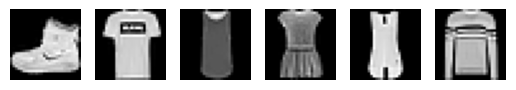

In [2]:
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import pyplot as plt
from tqdm.notebook import trange, tqdm
from torch.utils.data import DataLoader
from torchvision.datasets import FashionMNIST
from torchvision.transforms import ToTensor, ToPILImage
from torchvision.utils import make_grid

# Utiliser le GPU si disponible (pour accélérer les calculs)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Exécution sur {device}")

# Chargement des datasets. ToTensor() convertit l'image en un tenseur [0, 1]
train_dataset = FashionMNIST(root='./data/FashionMNIST', download=True, train=True, transform=ToTensor())
test_dataset = FashionMNIST(root='./data/FashionMNIST', download=True, train=False, transform=ToTensor())
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# Visualisation des premières images
n_images = 5
fig = plt.figure()
for i, (image, label) in enumerate(train_dataset):
    fig.add_subplot(1, n_images + 1, i + 1)
    plt.imshow(ToPILImage()(image), cmap="gray")
    plt.axis("off")
    if i >= n_images:
        break
plt.show()

---

## I. Auto-Encodeur (AE) Classique

L'AE vise à minimiser l'erreur de reconstruction entre l'entrée $\mathbf{x}$ et la sortie $\mathbf{x}'$ en passant par un **goulot d'étranglement** (le code latent $\mathbf{z}$) qui force la compression de l'information.

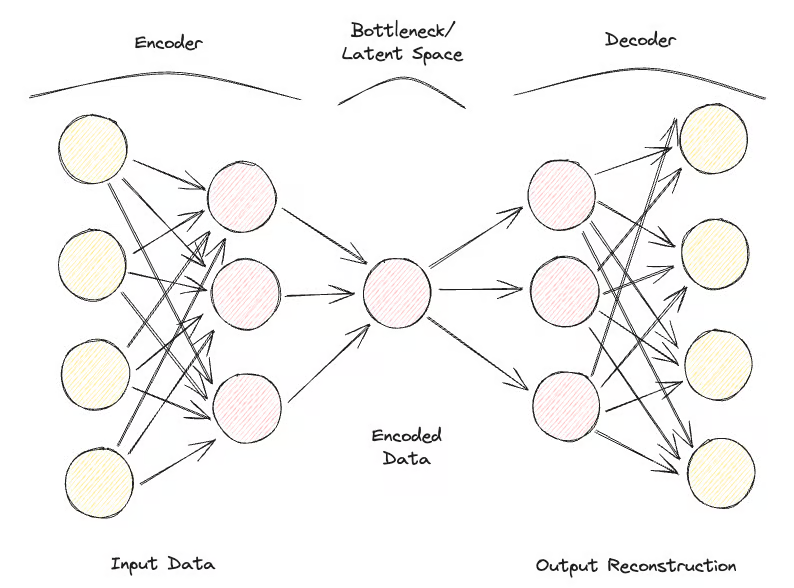

### 1.1. Architecture et Implémentation Détaillée

Nous utilisons une architecture **convolutive** pour capturer les caractéristiques spatiales des images. La dimension latente sera fixée à `latent_dimension = 10` (soit 784 pixels réduits à seulement 10 valeurs).

#### Rappel 

Le stride représente le nombre de pixels de déplacement du kernel à chaque étape.

- Stride = 1 → le filtre se déplace pixel par pixel.
- Stride = 2 → le filtre saute un pixel à chaque déplacement, ce qui réduit la taille de la sortie.

**Stride = 1**

![Alt Text](https://miro.medium.com/v2/resize:fit:720/format:webp/0*PwwAAFrpat2zNcsV.gif)

**Stride = 2**

![Alt_Text](https://miro.medium.com/v2/resize:fit:720/format:webp/0*CvEOVhChtGfcgZFb.gif)


**Formule de la convolution 2D**

Pour une **convolution 2D**, la taille de sortie $H_{out}$ et $W_{out}$ se calcule comme suit :


$$
H_{out} = \left\lfloor \frac{H_{in} - K + 2P}{S} \right\rfloor + 1
$$

$$
W_{out} = \left\lfloor \frac{W_{in} - K + 2P}{S} \right\rfloor + 1
$$

où :

| Symbole | Signification |
|---------| -------------- |
|$H_{in}$, $W_{in}$ | Taille d’entrée (hauteur, largeur) |
|$K$ | Taille du noyau (*kernel_size*) |
|$P$ | *Padding* ajouté autour de l’image |
|$S$ | *Stride* (le pas du filtre) |
|$\lfloor \cdot \rfloor$ | Partie entière (on arrondit vers le bas) |



---

In [3]:
latent_dimension = 10

class AutoEncoder(nn.Module):
    def __init__(self, latent_dimension):
        super(AutoEncoder, self).__init__()
        # --- ENCODER ---
        # Le rôle de l'encodeur est d'extraire les caractéristiques et de les compresser.
        self.encoder = nn.Sequential(
            # Conv 1: 28x28x1 -> 14x14x32 (avec stride 2)
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            # Conv 2: 14x14x32 -> 7x7x64
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(), # Transforme le 7x7x64 = 3136 en vecteur
            # Couche finale: 3136 -> latent_dimension (10)
            # in_features=64*7*7 = nombre d’entrées (3136 neurones)
            # out_features=latent_dimension = nombre de neurones en sortie (ici 10)
            nn.Linear(in_features=64*7*7, out_features=latent_dimension)
        )
       
        # --- DÉCODEUR ---
        # Le rôle du décodeur est de "décompresser" le code z pour reconstruire l'image.
        self.decoder_linear = nn.Linear(in_features=latent_dimension, out_features=64*7*7)
        # On choisit out_features = 64*7*7 car le décodeur doit recréer le même volume de caractéristiques 
        # (64 canaux de 7×7) que celui produit par le dernier bloc convolutionnel de l’encodeur, afin de 
        # pouvoir reconstruire correctement l’image originale.
        
        # Note Pédagogique: ConvTranspose2d (Déconvolution) augmente la résolution spatiale
        self.decoder = nn.Sequential(
            # Conv Transpose 1: 7x7x64 -> 14x14x32
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            # Conv Transpose 2: 14x14x32 -> 28x28x1
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid(), # Force la sortie à être entre [0, 1] (normalisation)
        )

    def forward(self, x):
        # 1. Encodage
        z = self.encoder(x)

        # 2. Décodage (étape linéaire et Reshape)
        hat_x = F.relu(self.decoder_linear(z)) #transforme ton vecteur latent de taille 10 en un grand vecteur de 3136 valeurs
        # Reconvertir le vecteur en grille pour les convolutions : (batch, 64, 7, 7)
        hat_x = hat_x.view(-1, 64, 7, 7) #view() (en PyTorch) sert à redimensionner un tenseur sans changer son contenu.
                                         #-1 → PyTorch devine automatiquement la taille du batch (ex: 128 ou 32).

        # 3. Décodage (étape convolutive)
        hat_x = self.decoder(hat_x)

        return hat_x, z # Retourne reconstruction (hat_x) et code latent (z)

net = AutoEncoder(latent_dimension)
net.to(device); #Cette ligne détermine où le modèle sera exécuté :soit sur le CPU (processeur),soit sur le GPU (carte graphique).
print("Modèle AE initialisé.")

Modèle AE initialisé.


### 1.2. Entraînement

**Fonction de coût (Loss)** : Nous utilisons l'Erreur Quadratique Moyenne (MSE) : $\mathcal{L}(\mathbf{x}, \mathbf{x}') = ||\mathbf{x} - \mathbf{x}'||^2$. Elle mesure la distance euclidienne entre l'image originale et sa reconstruction.

In [4]:
def train(net, train_dataset, epochs=10, learning_rate=1e-3, batch_size=128, device=device):
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    optimizer = torch.optim.Adam(params=net.parameters(), lr=learning_rate, weight_decay=1e-5)
    criterion = nn.MSELoss()
    net = net.to(device).train()

    t = trange(1, epochs + 1, desc="Entraînement de l'Auto-Encodeur")
    for epoch in t:
        avg_loss = 0.
        for images, _ in tqdm(train_dataloader):
            images = images.to(device)

            reconstructions, _ = net(images)
            loss = criterion(reconstructions, images)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            avg_loss += loss.item()

        avg_loss /= len(train_dataloader)
        t.set_description(f"Epoch {epoch}: loss = {avg_loss:.3f}")
    return net

net = train(net, train_dataset, epochs=10) 

Entraînement de l'Auto-Encodeur:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

### 1.3. Visualisation : Reconstruction et Débruitage (Denoising)

Un AE entraîné apprend implicitement à ignorer le bruit, car il n'est pas une caractéristique essentielle du jeu de données. Il peut donc servir de filtre de débruitage (*denoising*).

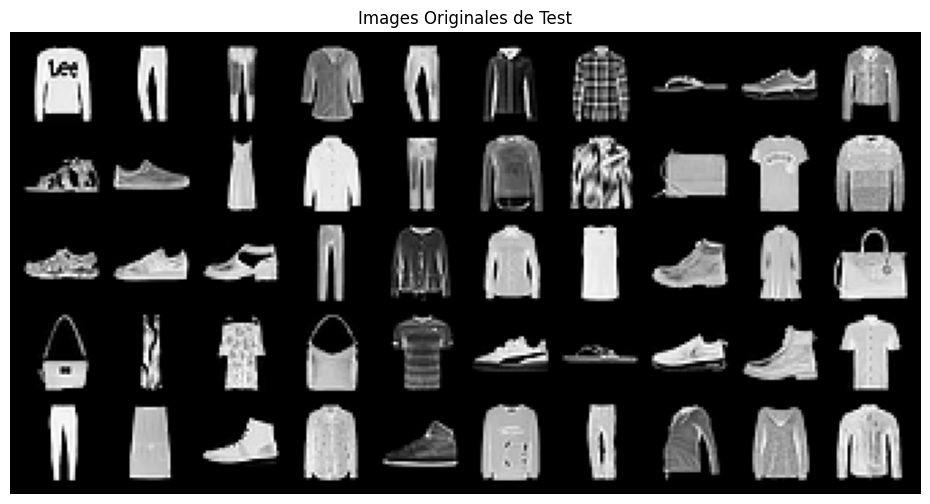

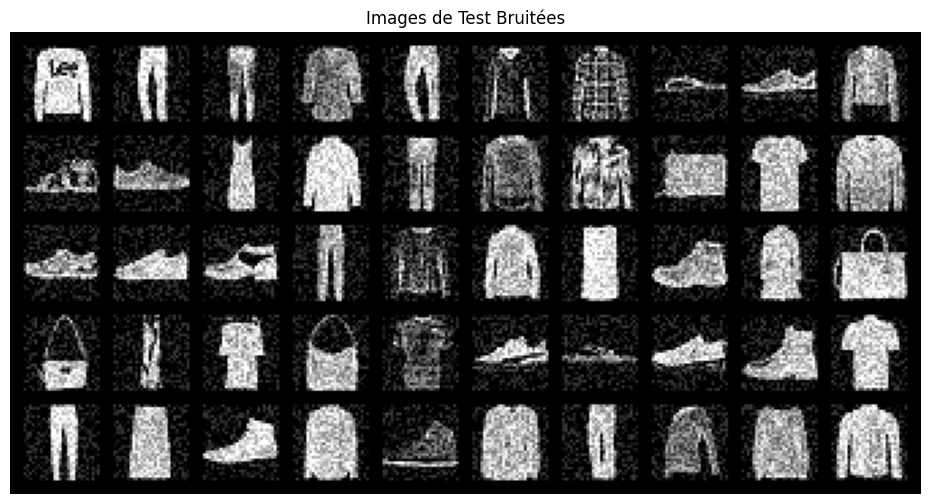

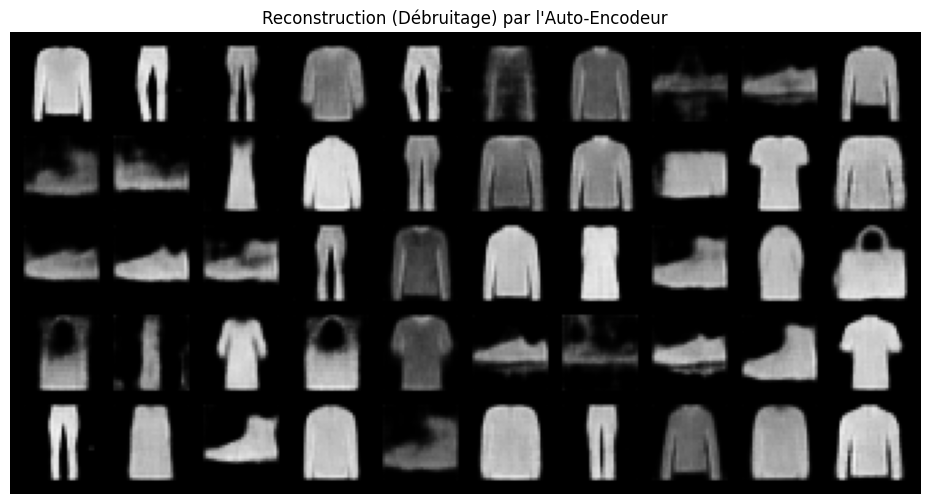

In [6]:
# Fonctions utilitaires de visualisation
def show_grid(grid, title="", figsize=(12, 6)):
    plt.figure(figsize=figsize)
    plt.title(title)
    # make_grid arrange les images en grille. numpy() et transpose (1, 2, 0) sont nécessaires pour matplotlib.
    plt.imshow(np.transpose(grid.numpy(), (1, 2, 0)))
    plt.axis("off")
    plt.show()

def visualize_reconstructions(net, images, device=device):
    net = net.to(device).eval()
    with torch.no_grad():
        images = images.to(device)
        reconstructions = net(images)[0]
        # make_grid arrange les 50 premières images en grille 10x5
        image_grid = make_grid(reconstructions[1:51], 10, 5).cpu()
        return image_grid

# Exemple de jeu de test
images, _ = next(iter(test_dataloader))


show_grid(make_grid(images[1:51],10,5), title="Images Originales de Test")

# Calcul du bruit
noise = torch.rand_like(images) - 0.5 #crée un bruit aléatoire entre [0, 1]. 
noisy_images = torch.clamp(images + 0.5 * noise, 0, 1) # Ajout de bruit et bornage [0, 1]

show_grid(make_grid(noisy_images[1:51],10,5), title="Images de Test Bruitées")

# IMPORTANT: DÉCOMMENTER UNIQUEMENT APRÈS AVOIR ENTRAÎNÉ LE MODÈLE (NET)
show_grid(visualize_reconstructions(net, noisy_images), title="Reconstruction (Débruitage) par l'Auto-Encodeur")

## Exercice 1: Auto-Encodeur Convolutif sur CIFAR-10

### Instructions

1. **Charger le dataset CIFAR-10** à l’aide de `torchvision.datasets.CIFAR10`.
   → Normalisez les images et créez les DataLoaders d’entraînement et de test.

2. **Construire un Auto-Encodeur Convolutif** :

   * L’encodeur doit réduire la taille des images (de 32×32×3 à un code latent, ex. 64 dimensions).
   * Le décodeur doit reconstruire l’image d’origine à partir du code latent.
   * Utilisez `Conv2d` et `ConvTranspose2d` avec des activations `ReLU` et une sortie `Sigmoid`.

3. **Entraîner le modèle** :

   * Utilisez l’optimiseur Adam (`lr = 1e-3`) et la fonction de perte MSE.
   * Affichez la perte moyenne à chaque époque.
   * Entraînez pendant environ **10 époques**.

4. **Tester la robustesse au bruit** :

   * Ajoutez un bruit aléatoire aux images de test (par ex. `+ 0.3 * torch.randn_like(images)`).
   * Passez ces images bruitées dans le modèle et observez la **reconstruction débruitée**.
   
6. **Visualiser les résultats :**

    * Affichez un échantillon d’images originales, bruitées et reconstruites côte à côte.
    * Comparez la qualité visuelle et commentez les différences.   

---

## II. Auto-Encodeur Variationnel (VAE)

Le VAE résout le problème de **discontinuité** de l'espace latent de l'AE en forçant cet espace à suivre une distribution Gaussienne simple ($\,\mathcal{N}(\mathbf{0}, \mathbf{I})$) grâce à une pénalité de régularisation (KL Divergence).

### 2.1. Concepts Clés du VAE

1.  **Sortie de l'Encodeur** : L'encodeur produit la **moyenne** $\boldsymbol{\mu}$ et le **log-variance** $\log(\boldsymbol{\sigma}^2)$ de la distribution latente, et non un simple point $\mathbf{z}$.
2.  **Astuce de Reparamétrisation** : Ces deux vecteurs sont utilisés pour générer un échantillon latent $\mathbf{z}$ via la reparamétrisation:
    $$\mathbf{z} = \boldsymbol{\mu} + \boldsymbol{\sigma} \odot \boldsymbol{\epsilon}, \quad \text{où } \boldsymbol{\epsilon} \sim \mathcal{N}(\mathbf{0}, \mathbf{I})$$
3.  **Fonction de Coût (ELBO Evidence Lower Bound))** : La fonction de coût est la somme de deux termes : la perte de **Reconstruction** et la **Divergence de Kullback-Leibler (KL)** (régularisation).

In [7]:
class Encoder(nn.Module):
    def __init__(self, latent_dimension):
        super(Encoder, self).__init__()
        # Partie convolutive identique à l'AE
        self.model = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
        )
        # Sorties séparées pour les paramètres de la distribution latente
        self.linear_mu = nn.Linear(in_features=64*7*7, out_features=latent_dimension) # Moyenne
        self.linear_logvar = nn.Linear(in_features=64*7*7, out_features=latent_dimension) # Log-Variance

    def forward(self, x):
        x = self.model(x)
        x_mu = self.linear_mu(x)
        x_logvar = self.linear_logvar(x)
        return x_mu, x_logvar

class Decoder(nn.Module):
    # Le décodeur reste inchangé (identique à l'AE)
    def __init__(self, latent_dimension):
        super(Decoder, self).__init__()
        self.linear = nn.Linear(in_features=latent_dimension, out_features=64*7*7)
        self.model = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid(),
        )

    def forward(self, z):
        hat_x = F.relu(self.linear(z))
        hat_x = hat_x.view(-1, 64, 7, 7)
        hat_x = self.model(hat_x)
        return hat_x

In [8]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dim):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)

    def forward(self, x):
        latent_mu, latent_logvar = self.encoder(x)
        # Étape cruciale : l'échantillonnage avec reparamétrisation
        z = self.latent_sample(latent_mu, latent_logvar)
        hat_x = self.decoder(z)
        return hat_x, latent_mu, latent_logvar # Les 3 sorties sont nécessaires pour la loss

    def latent_sample(self, mu, logvar):
        # L'astuce de reparamétrisation n'est appliquée qu'à l'entraînement
        if self.training:
            # 1. sigma = exp(0.5 * logvar)
            std = logvar.mul(0.5).exp_()
            # 2. epsilon ~ N(0, I)
            eps = torch.empty_like(std).normal_()
            # 3. z = mu + sigma * epsilon
            return eps.mul(std).add_(mu)
        else:
            # En inférence, on prend simplement le point le plus probable (la moyenne)
            return mu

vae = VariationalAutoencoder(latent_dimension)
vae.to(device);
print("Modèle VAE initialisé.")

Modèle VAE initialisé.


### 2.2. Fonction de Coût du VAE (ELBO)

La fonction de coût du VAE est : $\text{Loss} = \text{Reconstruction Loss} + \beta \times \text{KL Divergence}$.

1.  **Reconstruction Loss (BCE)** : Utilise l'Entropie Croisée Binaire (BCE) pour les images.
2.  **KL Divergence** : Formule analytique entre $q_{\phi}(\mathbf{z}|\mathbf{x}) = \mathcal{N}(\boldsymbol{\mu}, \boldsymbol{\sigma}^2)$ et $p(\mathbf{z}) = \mathcal{N}(\mathbf{0}, \mathbf{I})$ :
    $$KL = \frac{1}{2} \sum_j^d \bigl ( 1 + \log((\sigma_j)^2) - (\mu_j)^2 - (\sigma_j)^2 \bigr)$$

In [9]:
beta = 1.0 # Paramètre du beta-VAE

def vae_loss(hat_x, x, mu, logvar):
    # Terme 1: Reconstruction Loss (BCE)
    # Réduction='sum' car on veut la perte totale du batch, non la moyenne par pixel
    reconstruction_loss = F.binary_cross_entropy(hat_x.view(-1, 28*28), x.view(-1, 28*28), reduction='sum')

    # Terme 2: KL Divergence Loss
    # Formule: -0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # Loss finale
    return reconstruction_loss + beta * kl_divergence

### 2.3. Entraînement

La fonction d'entraînement est adaptée pour utiliser les trois sorties du VAE (`hat_x`, `mu`, `logvar`) dans le calcul de la `vae_loss`.

In [10]:
def train_vae(net, train_dataset, epochs=10, learning_rate=1e-3, batch_size=128, device=device):
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    optimizer = torch.optim.Adam(params=net.parameters(), lr=learning_rate, weight_decay=1e-5)
    net = net.to(device).train()

    t = trange(1, epochs + 1, desc="Entraînement du VAE")
    for epoch in t:
        avg_loss = 0.
        for images, _ in tqdm(train_dataloader):
            images = images.to(device)

            reconstructions, latent_mu, latent_logvar = net(images)
            loss = vae_loss(reconstructions, images, latent_mu, latent_logvar)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            avg_loss += loss.item()

        avg_loss /= len(train_dataloader)
        t.set_description(f"Epoch {epoch}: loss = {avg_loss:.3f}")
    return net.to("cpu")

vae = train_vae(vae, train_dataset, epochs=10)

Entraînement du VAE:   0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

### 2.4. Génération et Interpolation (Le Cœur du VAE)

Grâce à la régularisation de la KL, l'espace latent est structuré, dense et suit la loi $\mathcal{N}(\mathbf{0}, \mathbf{I})$, permettant la génération par échantillonnage aléatoire.

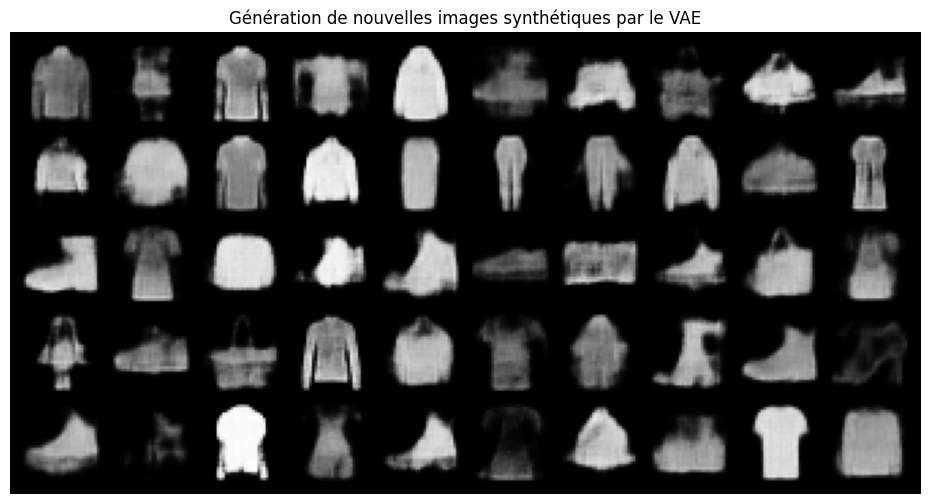

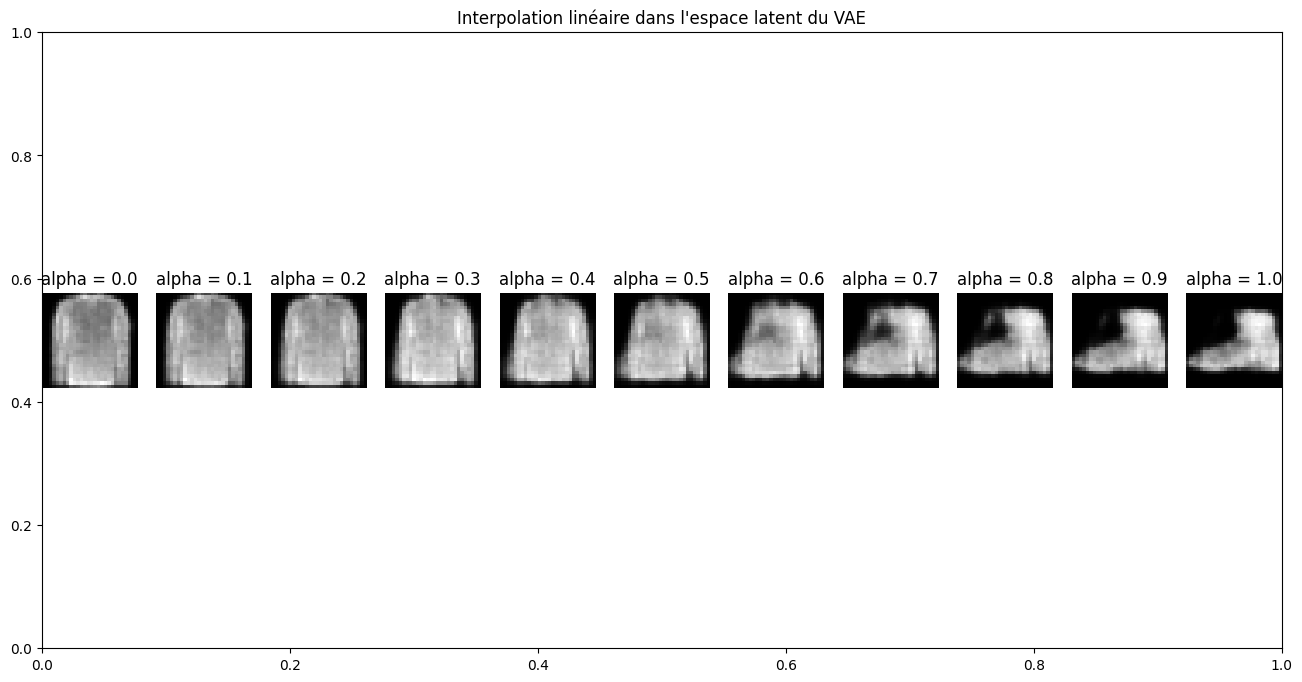

In [14]:
vae = vae.to(device)
vae.eval()
with torch.no_grad():
    # 1. Génération : Échantillonnage de 100 vecteurs latents N(0, I)
    latent = torch.randn(100, latent_dimension, device=device)

    # 2. Décodage pour obtenir les images synthétiques
    fake_images = vae.decoder(latent).cpu()

show_grid(make_grid(fake_images[1:51], 10, 5), title="Génération de nouvelles images synthétiques par le VAE")



#--- Interpolation ---
#z1 et z2 sont deux points aléatoires
z1 = torch.randn(1, latent_dimension, device=device)
z2 = torch.randn(1, latent_dimension, device=device)
n_steps = 10

fig = plt.figure(figsize=(16, 8))
plt.title("Interpolation linéaire dans l'espace latent du VAE")

for idx, alpha in enumerate(np.linspace(0, 1, n_steps + 1)):
    # Interpolation: z = (1 - alpha) * z1 + alpha * z2
    z_interpolated = (1 - alpha) * z1 + alpha * z2
    with torch.no_grad():
        fake_image = vae.decoder(z_interpolated)[0, 0, :, :].cpu().numpy()

    fig.add_subplot(1, n_steps + 1, idx + 1)
    plt.imshow(fake_image, cmap="gray")
    plt.title(f"alpha = {alpha:0.1f}")
    plt.axis('off')
plt.show()

---

## III. Approfondissement (Optionnel) : Visualisation de l'Espace Latent

Cet exercice utilise **t-SNE** pour projeter les codes latents en 2D et visualiser l'effet de la régularisation KL sur la structure de l'espace.

### Question

*(Optionnel, pour l'approfondissement)* Pour toutes les images du jeu de test de Fashion-MNIST, calculer le code latent associé (on prendra la moyenne $\boldsymbol{\mu}$ dans le cas du VAE). Appliquer une réduction de dimension non-linéaire en utilisant la version de `t-SNE` de `scikit-learn` pour projeter les codes latents dans le plan. Coloriez les points en fonction de leur catégorie.

**Que constatez-vous ?**

* **AE Classique** : Les clusters de classes sont isolés, avec de grands espaces vides entre eux (points incohérents).
* **VAE** : Les clusters sont regroupés autour du centre $(\mathbf{0})$, l'espace est dense et continu, permettant l'interpolation fluide.

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.036s...
[t-SNE] Computed neighbors for 10000 samples in 2.307s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.648653
[t-SNE] KL divergence after 250 iterations with early exaggeration: 80.007240
[t-SNE] KL divergence after 1000 iterations: 1.614845


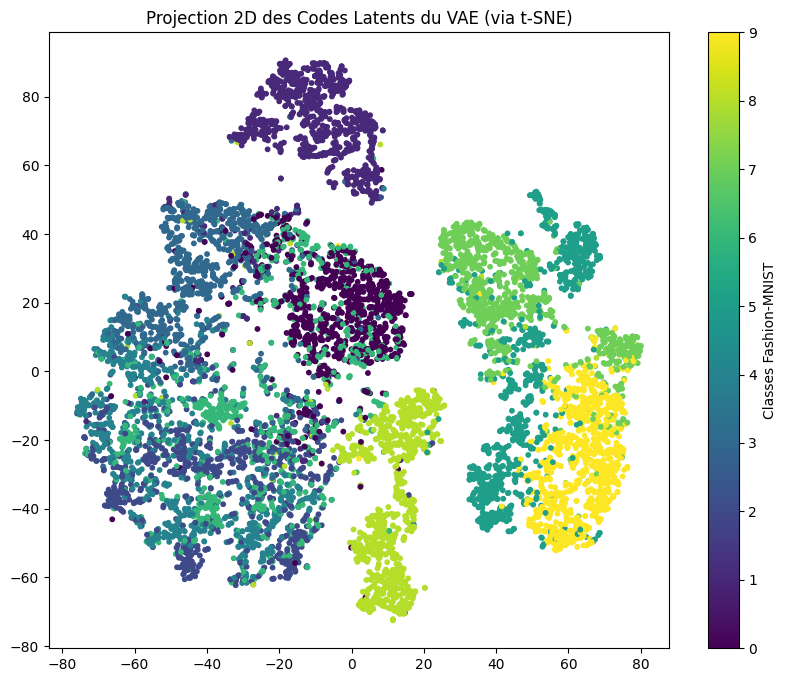

In [16]:
from sklearn.manifold import TSNE
from torch.utils.data import ConcatDataset

# 1. Extraction des codes latents du VAE
all_latents = []
all_labels = []
vae.eval()
for images, labels in test_dataloader:
    images = images.to(device)
    # On récupère la moyenne (mu) comme point latent
    mu, _ = vae.encoder(images)
    all_latents.append(mu.detach().cpu().numpy())
    all_labels.append(labels.numpy())

latents = np.concatenate(all_latents, axis=0)
labels = np.concatenate(all_labels, axis=0)

# 2. Réduction de dimension avec t-SNE
tsne = TSNE(n_components=2, random_state=42, verbose=1)
latents_2d = tsne.fit_transform(latents)

# 3. Visualisation
plt.figure(figsize=(10, 8))
scatter = plt.scatter(latents_2d[:, 0], latents_2d[:, 1], c=labels, cmap='viridis', s=10)
plt.colorbar(scatter, label='Classes Fashion-MNIST')
plt.title('Projection 2D des Codes Latents du VAE (via t-SNE)')
plt.show()